In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
from datetime import date
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel,VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import pickle
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
date = date.today()
folder_path  = '/content/drive/MyDrive/honeypot'
dataset_path=os.path.join(folder_path,"data")
result_main_path=os.path.join(folder_path,"results")
results_path=os.path.join(result_main_path,str(date))
svm_model_name='svm.sav'
LR_model_name='lr.sav'
svm_model_path= os.path.join(result_main_path,svm_model_name)
LR_model_path= os.path.join(result_main_path,LR_model_name)
try:
    os.mkdir(results_path)
    print('[Success] Created folder')
except Exception as e:
    print(e)

[Success] Created folder


In [ ]:
X = pd.read_csv(os.path.join(dataset_path,'features.csv'))#read features
y = pd.read_csv(os.path.join(dataset_path,'labels.csv'))#read lables

In [ ]:
print(X.shape, y.shape)

(12340, 21) (12340, 1)


In [ ]:
dataset = pd.concat([X, y], axis=1)#x and y concatanated 

In [ ]:
dataset

,Source Port,Destination Port,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Flow Bytes/s,Fwd IAT Total,Fwd Header Length,...,Max Packet Length,Packet Length Mean,ACK Flag Count,Average Packet Size,Avg Fwd Segment Size,Fwd Header Length.1,Subflow Fwd Bytes,min_seg_size_forward,Inbound,Label
0,8389,22800,1,0.0,0.0,0.0,0.0,0.000000e+00,1.0,40,...,0.0,0.0,1,0.0,0.0,40,0,20,1,9
1,691,33138,49,2944.0,1472.0,1472.0,1472.0,6.008163e+07,49.0,0,...,1472.0,1472.0,0,2208.0,1472.0,0,2944,0,1,4
2,766,55485,1,2944.0,1472.0,1472.0,1472.0,2.944000e+09,1.0,16,...,1472.0,1472.0,0,2208.0,1472.0,16,2944,8,1,4
3,705,42032,1,458.0,229.0,229.0,229.0,4.580000e+08,1.0,40,...,229.0,229.0,0,343.5,229.0,40,458,20,1,5
4,27143,50006,97,0.0,0.0,0.0,0.0,0.000000e+00,1.0,40,...,0.0,0.0,1,0.0,0.0,40,0,20,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12335,634,56423,108,4400.0,440.0,440.0,440.0,4.074074e+07,108.0,80,...,440.0,440.0,0,484.0,440.0,80,4400,8,1,7
12336,979,1068,1,458.0,229.0,229.0,229.0,4.580000e+08,1.0,40,...,229.0,229.0,0,343.5,229.0,40,458,20,1,5
12337,44733,1031,49,0.0,0.0,0.0,0.0,0.000000e+00,49.0,40,...,0.0,0.0,1,0.0,0.0,40,0,20,1,8
12338,36181,35530,1,766.0,383.0,383.0,383.0,7.660000e+08,1.0,40,...,383.0,383.0,0,574.5,383.0,40,766,20,1,2


# removing classes

In [ ]:
index = dataset[(dataset['Label'] == 2) | (dataset['Label'] == 4) |( dataset['Label'] == 6) | (dataset['Label'] == 11)].index
dataset.drop(index , inplace=True)


In [ ]:
for i in range(0,12):
  if (len (dataset[dataset['Label']==i])==0):
    for i in range(i,12):
      dataset['Label'].mask(dataset['Label'] ==i+1 ,i, inplace=True)#reorganize the lables, lables are renamed between 0-7

In [ ]:
dataset.shape
X = dataset.drop(['Label'], axis=1)
y = dataset['Label']
print(X.shape, y.shape)

(8340, 21) (8340,)


# PRE-PROCESSING

In [ ]:
for col in dataset.columns:
    print(col)

Source Port
Destination Port
Flow Duration
Total Length of Fwd Packets
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Flow Bytes/s
Flow IAT Max
Fwd IAT Total
Fwd Header Length
Min Packet Length
Max Packet Length
Packet Length Mean
ACK Flag Count
Average Packet Size
Avg Fwd Segment Size
Fwd Header Length.1
Subflow Fwd Bytes
min_seg_size_forward
Label


In [ ]:
# sns.set_style("whitegrid")
# sns.FacetGrid(dataset, hue="Label", height=16).map(plt.scatter, "Source Port", "Destination Port").add_legend(labels=[
#     'bengins', 
#     'mssql',
#     'ssdp',
#     'dns',
#     'ldap',   
#     'netbios',
#     'snmp',
#     'ntp',
#     'tftp',
#     'syns',
#     'udps',
#     'udpLags'])
# plt.show()

In [ ]:
mssql=dataset.loc[dataset['Label']==1]
ssdp=dataset.loc[dataset['Label']==2]
dns=dataset.loc[dataset['Label']==3]
ldap=dataset.loc[dataset['Label']==4]
netbios=dataset.loc[dataset['Label']==5]
snmp=dataset.loc[dataset['Label']==6]
ntp=dataset.loc[dataset['Label']==7]
tftp=dataset.loc[dataset['Label']==8]
syns=dataset.loc[dataset['Label']==9]
udps=dataset.loc[dataset['Label']==10]
udpLags=dataset.loc[dataset['Label']==11]
bengins=dataset.loc[dataset['Label']==0]
#according to the lable data were classified from the dataset


In [ ]:
dataset_set1 = pd.concat([syns,udps])#create subdata set with desired classes

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


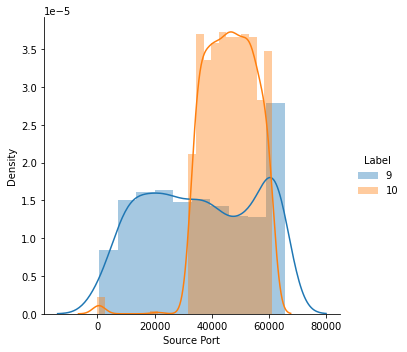

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


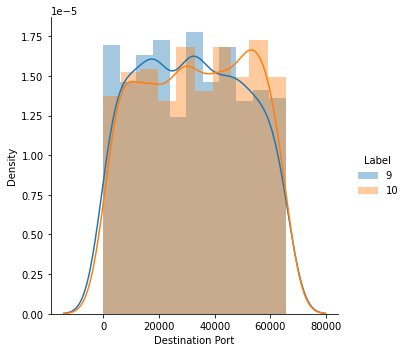

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


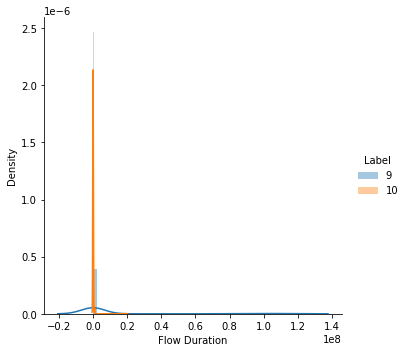

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

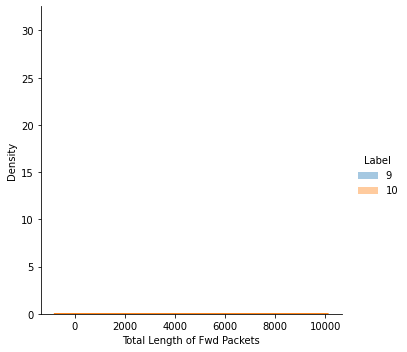

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

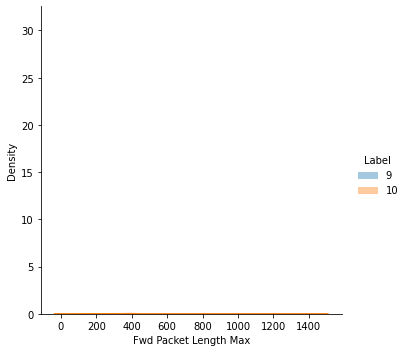

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

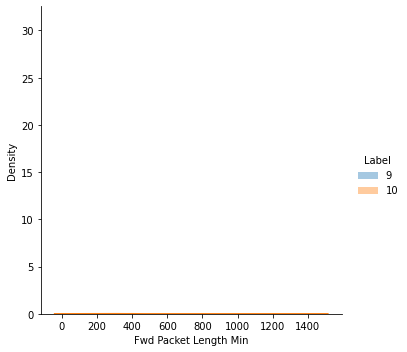

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

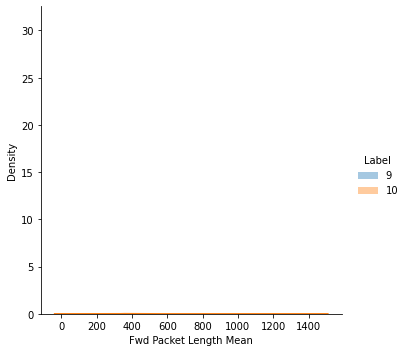

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

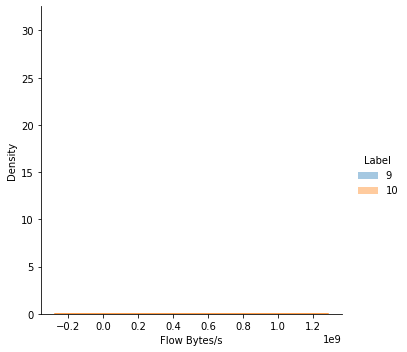

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


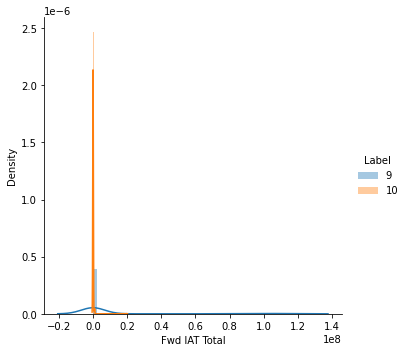

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


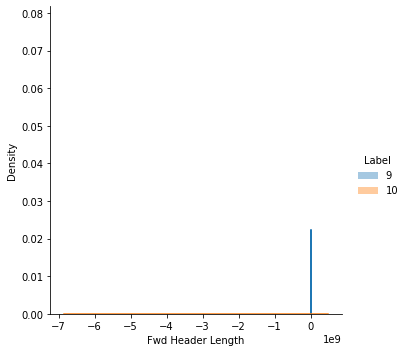

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


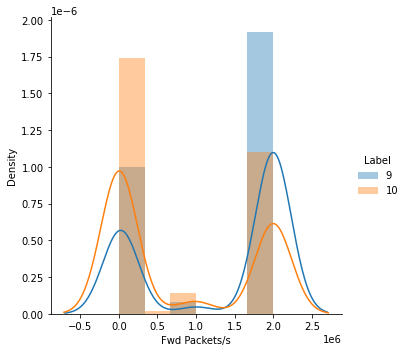

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

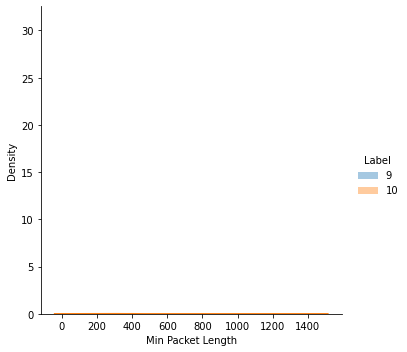

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

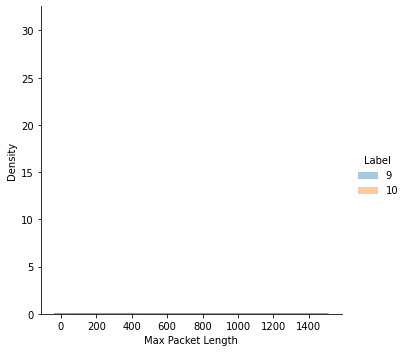

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

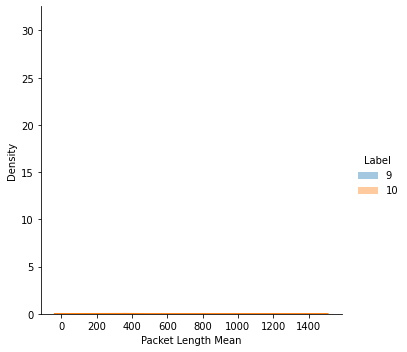

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

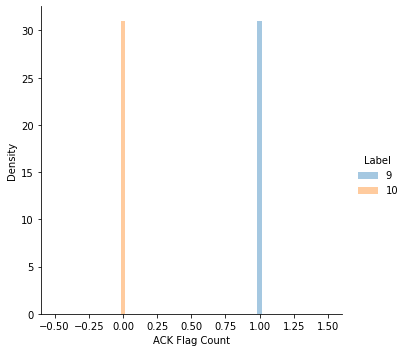

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

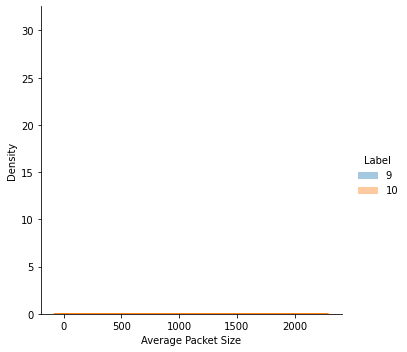

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

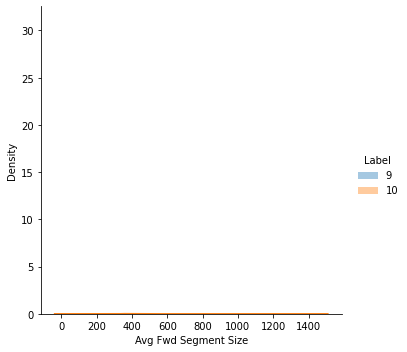

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


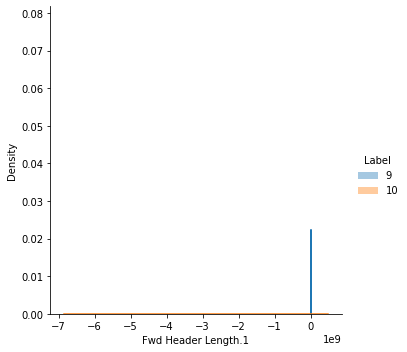

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

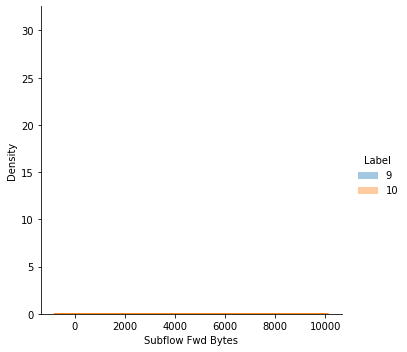

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

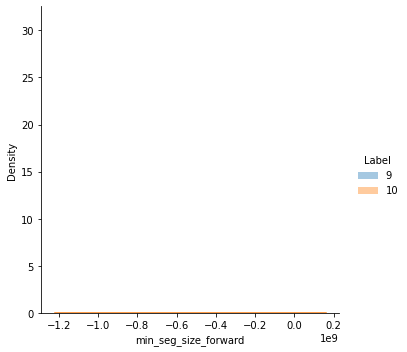

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

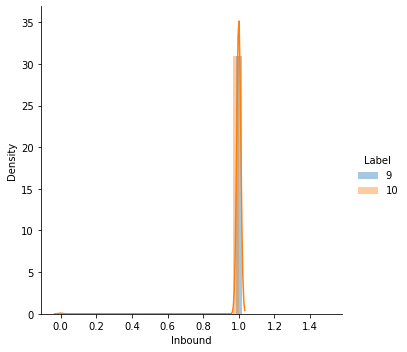

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simi

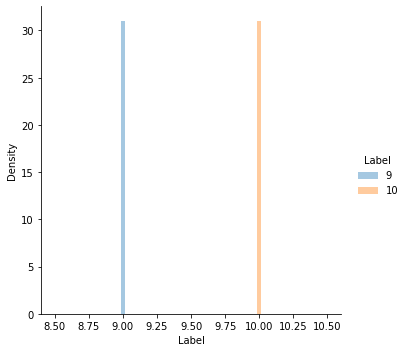

In [ ]:
for col in dataset.columns:

  g=sns.FacetGrid(dataset_set1,hue='Label',size=5).map(sns.distplot,col).add_legend()
  g.tight_layout()
  g.savefig('{}.png'.format(col.replace("/", "") ))

  plt.show()

# TRAINING

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5,random_state=20)#data set was devided  per 50% as test and train data

In [ ]:
print(X_train.shape, y_train.shape)

(4170, 21) (4170,)


## Support Vector Machine

In [ ]:
param_grid={'kernel':['rbf','poly','sigmoid'],
            'C':[0.001,0.005,0.01,0.05,0.1,0.5,1,5],
            'gamma':[0.00001,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
            }

In [ ]:
svm_classifier=svm.SVC()
grid = GridSearchCV(svm_classifier, param_grid, refit = True, verbose = 3)

In [ ]:
grid.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END ..C=0.001, gamma=1e-05, kernel=rbf;, score=0.086 total time=   2.5s
[CV 2/5] END ..C=0.001, gamma=1e-05, kernel=rbf;, score=0.086 total time=   2.5s
[CV 3/5] END ..C=0.001, gamma=1e-05, kernel=rbf;, score=0.086 total time=   2.5s
[CV 4/5] END ..C=0.001, gamma=1e-05, kernel=rbf;, score=0.086 total time=   2.5s
[CV 5/5] END ..C=0.001, gamma=1e-05, kernel=rbf;, score=0.086 total time=   2.5s


In [ ]:
grid.best_params_

In [ ]:
grid.score(X_test, y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4,random_state=20)

In [ ]:
# X_train=X_train[0:200]
# y_train=y_train[0:200]

In [ ]:
tuned_svm_classifier=svm.SVC(C=0.5,gamma=0.1,kernel='sigmoid',verbose=True)

In [ ]:
tuned_svm_classifier.fit(X_train, y_train.values.ravel())

[LibSVM]

SVC(C=0.5, gamma=0.1, kernel='sigmoid', verbose=True)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


0.12697095435684647


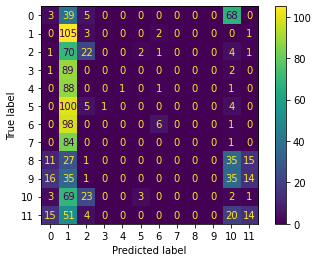

ValueError: ignored

In [ ]:
preds=tuned_svm_classifier.predict(X_test)
acc_svm = tuned_svm_classifier.score(X_test, y_test)
print(acc_svm)
cm=confusion_matrix(y_test, preds,labels=tuned_svm_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=tuned_svm_classifier.classes_)
disp.plot()
plt.show()
target_names = ['bengin', 
                     'syn',
                     'udp',
                    
                     'dns',
                   
                     'mssql',
                  
                     'ntp',
                     ]
print(classification_report(y_test, preds, target_names=target_names))

In [ ]:
pickle.dump(tuned_svm_classifier, open(svm_model_path, 'wb'))


## LOGISTIC REGRESSION

In [ ]:
logisticRegr=LogisticRegression(solver='lbfgs', max_iter=3000)

In [ ]:
from sklearn import preprocessing

X_train = preprocessing.scale(X_train)


In [ ]:
logisticRegr.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=3000)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.14854771784232365


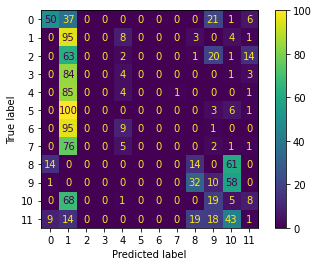

In [ ]:
preds=logisticRegr.predict(X_test)
acc_svm = logisticRegr.score(X_test, y_test)
print(acc_svm)
cm=confusion_matrix(y_test, preds,labels=logisticRegr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logisticRegr.classes_)
disp.plot()
plt.show()
# target_names = ['BENIGN','SYN']
# print(classification_report(y_test, preds, target_names=target_names))

In [ ]:
pickle.dump(logisticRegr, open(LR_model_path, 'wb'))

##KNEIGHBOURS

In [ ]:
knn = KNeighborsClassifier()#initialize knearest neighbor

k_range = list(range(1, 10))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=True,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train.values.ravel())

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [ ]:
print(grid_search.best_params_)

{'n_neighbors': 1}


In [ ]:
nbrs = KNeighborsClassifier(n_neighbors=1)#new object create with the hyperparamter tuned value

In [ ]:
nbrs.fit(X_train, y_train.values.ravel())#trained th emodel with trained data

KNeighborsClassifier(n_neighbors=1)

0.9009592326139089


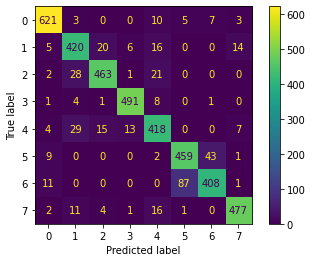

              precision    recall  f1-score   support

     bengins       0.95      0.96      0.95       649
       mssql       0.85      0.87      0.86       481
         dns       0.92      0.90      0.91       515
     netbios       0.96      0.97      0.96       506
         ntp       0.85      0.86      0.86       486
        tftp       0.83      0.89      0.86       514
        syns       0.89      0.80      0.84       507
        udps       0.95      0.93      0.94       512

    accuracy                           0.90      4170
   macro avg       0.90      0.90      0.90      4170
weighted avg       0.90      0.90      0.90      4170



In [ ]:
preds=nbrs.predict(X_test)
acc_svm = nbrs.score(X_test, y_test)
print(acc_svm)
cm=confusion_matrix(y_test, preds,labels=nbrs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=nbrs.classes_)
disp.plot()
plt.show()

target_names =[
    'bengins', 
    'mssql',
    #'ssdp',
    'dns',
    # 'ldap',   
    'netbios',
   # 'snmp',
    'ntp',
    'tftp',
    'syns',
   'udps',
   # 'udpLags'
   ]
print(classification_report(y_test, preds, target_names=target_names))

# Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
desTree = DecisionTreeClassifier( )

desTree.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier()

0.9589928057553957


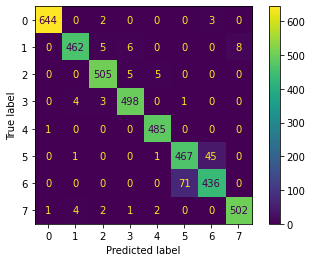

              precision    recall  f1-score   support

     bengins       1.00      0.99      0.99       649
       mssql       0.98      0.96      0.97       481
         dns       0.98      0.98      0.98       515
     netbios       0.98      0.98      0.98       506
         ntp       0.98      1.00      0.99       486
        tftp       0.87      0.91      0.89       514
        syns       0.90      0.86      0.88       507
        udps       0.98      0.98      0.98       512

    accuracy                           0.96      4170
   macro avg       0.96      0.96      0.96      4170
weighted avg       0.96      0.96      0.96      4170



In [ ]:
preds=desTree.predict(X_test)
acc_svm = desTree.score(X_test, y_test)
print(acc_svm)
cm=confusion_matrix(y_test, preds,labels=desTree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=desTree.classes_)
disp.plot()
plt.show()
# target_names = ['bengin', 
#                      'syn',
#                      'udp',
                    
#                      'dns',
                   
#                      'mssql',
                  
#                      'ntp',
#                      ]
target_names =[
    'bengins', 
    'mssql',
    #'ssdp',
    'dns',
    # 'ldap',   
    'netbios',
   # 'snmp',
    'ntp',
    'tftp',
    'syns',
   'udps',
   # 'udpLags'
   ]
print(classification_report(y_test, preds, target_names=target_names))

In [ ]:
filename_desTree = 'decisionTree.sav'
fielname_nbrs='kneighbor.sav'
pickle.dump(desTree, open(filename_desTree, 'wb'))
pickle.dump(nbrs, open(fielname_nbrs, 'wb'))